## Scaffold Testing for Figure 2: Library Imports and Setup

This notebook implements the scaffold capacity testing experiments shown in Figure 2 of the paper. The imports include:

- **numpy & matplotlib**: Basic numerical computation and visualization
- **scipy.stats**: Statistical analysis for capacity measurements
- **src.assoc_utils_np**: Core associative memory functions including:
  - `train_gcpc()`: Trains grid-cell to place-cell connections using pseudo-inverse rule
  - `nonlin()`: Applies rectified linear activation with threshold
  - `capacity_gcpc_vectorized()`: Vectorized capacity testing function
- **src.theory_utils**: Theoretical analysis tools for capacity bounds
- **src.data_utils**: Data processing utilities for saving/loading results
- **src.assoc_utils_np_2D**: 2D-specific functions:
  - `gen_gbook_2d()`: Generates 2D grid cell codebooks with hexagonal tiling

In [1]:
# Import necessary libraries and modules
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting graphs and visualizations
import matplotlib as mpl  # For advanced plotting configurations
from scipy import stats  # For statistical computations
from src.assoc_utils_np import *  # Import associative memory utilities
from src.theory_utils import *  # Import theoretical analysis utilities
from src.data_utils import *  # Import data processing utilities
from src.assoc_utils_np_2D import gen_gbook_2d  # Function to generate 2D grid codebooks
plt.style.use('./src/presentation.mplstyle')  # Use a predefined plotting style

## Key Parameters and Variables Reference

This table provides detailed information about the most important parameters and variables used throughout the notebook:

| **Parameter** | **Shape** | **Meaning & Interpretation** |
|---------------|-----------|------------------------------|
| **`lambdas`** | `(3,)` | Grid cell module periods `[3, 4, 5]`. Each value defines the spatial period of one grid module in linear dimensions. |
| **`Ng`** | Scalar | Total number of grid cells = 3² + 4² + 5² = 50. Sum of all grid cells across modules. |
| **`Np_lst`** | `(2,)` | List of place cell counts `[25, 350]`. Tests sparse vs. dense place cell encoding scenarios. |
| **`Npos`** | Scalar | Total spatial positions = (3×4×5)² = 3600. Number of unique locations in 2D space that can be encoded. |
| **`Npatts_lst`** | `(36,)` | Pattern count array `[1, 101, 201, ..., 3501]`. Different numbers of memory patterns to test network capacity. |
| **`gbook`** | `(50, 3600)` | **Grid cell codebook matrix**. Each row represents one grid cell's spatial firing map across all 3600 positions. Each column represents the activation state of all 50 grid cells at a specific spatial location. |
| **`pbook`** | `(1, Np, 3600)` | **Place cell codebook matrix**. For each run, each row represents one place cell's spatial firing pattern. Derived from grid cells through learned connections. |
| **`Wpg`** | `(1, Np, 50)` | **Grid→Place connection weights**. Fixed random weights (60% sparse) that transform grid cell activations into place cell responses. |
| **`Wgp`** | `(50, Np)` | **Place→Grid connection weights**. Learned through pseudo-inverse rule to enable memory retrieval from place cells back to grid cells. |
| **`err_gcpc`** | `(2, 36, 1)` | **Reconstruction error matrix**. Normalized L2 error for each combination of: place cell count (2 values，In the example, it is 25 or 350.), pattern count (36 values), experimental run (1 run). Values near 0 indicate successful memory retrieval. Example 1: 25 place cells, storing 101 patterns, reconstruction error of the first run err_gcpc[0, 1, 0] = 0.0005,which means the error is very small, reconstruction successful.|
| **`num_correct`** | `(2, 36, 1)` | **Success count matrix**. Number of patterns successfully reconstructed (error < 0.003) for each experimental configuration. Higher values indicate better memory capacity. |

### **Key Relationships:**
- **Grid cells encode space periodically**: Each grid cell in `gbook[i, :]` shows where cell `i` fires across the 2D environment
- **Place cells encode space sparsely**: Each place cell in `pbook[run, j, :]` shows where cell `j` fires, derived from grid cells via `Wpg`
- **Memory storage**: `Wgp` learns to map place cell patterns back to their corresponding grid cell states
- **Memory retrieval**: The network uses grid cell structure to correct errors and retrieve stored memories

## Parameter Configuration for Scaffold Network

This cell sets up the fundamental parameters for the grid-cell scaffold network:

- **lambdas = [3,4,5]**: Periods of grid cell modules in linear dimensions. Each module creates a periodic tiling pattern.
- **Ng**: Total number of grid cells = 3² + 4² + 5² = 50 cells
- **Np_lst**: List of place cell numbers to test (25 and 350)
- **pflip**: Noise parameter for corrupting patterns (set to 0 for noise-free testing)
- **Niter**: Number of iterations for scaffold dynamics (2 iterations for convergence)

  *p.s.:* This is the essential idea!One iteration of sacaffold dynamics means that input activates the grid state and then activates the HPC state,and thru backpropgation,the grid state corrects itself
- **Npos**: Total number of spatial positions = (3×4×5)² = 3600 positions
- **Npatts_lst**: Range of pattern numbers to test (1 to 3600 in steps of 100)

In [2]:
lambdas = [3,4,5]                  # module period (linear dimension)
m = len(lambdas)
Ng = np.sum(np.square(lambdas))                           # num grid cells
# Np_lst=np.arange(25,350,250)
Np_lst=[25,350]
pflip = 0.                      # param controling injected noise
Niter = 2                         # number of iterations for scaffold dynamics
Npos = np.prod(lambdas)**2
nruns = 1  # number of runs you want to average the results over
Npatts_lst = np.arange(1,Npos+1,100) # this is a function to generate a list of pattern counts


## Grid Codebook Generation: Different Ordering Strategies

This cell generates the grid cell codebook (gbook) which defines how grid cells respond to different spatial positions. Three different ordering strategies are available:

gbook is a matrix which has a shape of `(Ng, Npos)`.
- Each column represents the activation states of all grid cells at a certain spatial position;
- each row represents the response profile (i.e.,**firing map**) of a grid cell across all positions.

### 1. **Optimal/Rank Ordered** (Currently Active)
- Orders patterns by their similarity/rank for fastest generalization
- Uses theoretical optimal ordering proven to maximize capacity
- Generated by `gen_gbook()` with squared periods

*p.s.:* The gbook returned by gen_gbook is a **three-dimensional vector** that has not yet been flattened in the x and y directions.
### 2. **Hairpin Ordering** (Commented Out)
- Row-by-row covering of the 2D grid space
- Creates a "hairpin" or zigzag pattern through space
- More biologically plausible spatial traversal

### 3. **Spiral Ordering** (Commented Out)
- Spiraling outward from center in contiguous regions
- Models natural exploration patterns
- Uses `make_spiral()` to generate outward spiral trajectory

The choice of ordering significantly affects the network's generalization capacity and learning dynamics.

In [3]:
## Choose ordering used to make gbook: 
#optimal generalization/rank ordered corresponds to ordering used in the proof for fastest generalization
#Spiral is a spiraling outward contiguous region of the grid coding space
#Hairpin is a row-by-row covering of the grid space

## optimal generalization gbook (is also rank ordered)
print('optimal gbook')
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)#10000)#


### hairpin gbook
# print('hairpin gbook')
# gbook = gen_gbook_2d(lambdas, Ng, np.prod(lambdas))
# gbook = gbook.reshape(Ng, np.prod(lambdas)**2)


## spiral gbook
# print('spiral gbook')
# gbook_hp = gen_gbook_2d(lambdas, Ng, np.prod(lambdas))
# gbook_hp = gbook_hp.reshape(Ng, np.prod(lambdas)**2)
# x,y=make_spiral(np.prod(lambdas))
# locs1=np.prod(lambdas)*y+x
# gbook = gbook_hp[:,locs1]

optimal gbook


## Experimental Conditions: Testing Different Network Configurations

This cell runs capacity testing experiments under different conditions. Multiple experimental variants are available:

### **Base Case** (Currently Active)
- `capacity_gcpc_vectorized()`: Tests the standard Vector-HaSH network
- Uses structured grid cell patterns and learned place cell representations
- Tests capacity without generalization (`test_generalization='no'`)

**Function Input/Output:**
- **Inputs**: 
  - `lambdas`: Grid cell module periods [3,4,5]
  - `Ng`: Number of grid cells (50)
  - `Np_lst`: List of place cell counts to test [25, 350]
  - `pflip`: Noise level (0.0 for noise-free)
  - `Niter`: Scaffold dynamics iterations (2)
  - `Npos`: Total spatial positions (3600)
  - `gbook`: Grid cell codebook matrix (50×3600)
  - `nruns`: Number of experimental runs (1)
  - `Npatts_lst`: Pattern counts to test [1, 101, 201, ..., 3501]
  - `test_generalization`: If you choose NO, then the test will only check whether it can restore the patts stored during training; if you choose YES, then the test will check whether it can generalise to other patts.

- **Outputs**:
  - `err_gcpc`: Reconstruction error matrix (2×36×1) - normalized L2 error for each Np, pattern count, and run
  - `num_correct`: Success count matrix (2×36×1) - number of patterns successfully reconstructed (error < 0.003)

### **Alternative Conditions** (Commented Out)

1. **Random Sparse Place Cells**
   - `capacity_gcpc_random_sparse_p()`: Place cells are random vectors with same sparsity as base case
   - Corresponds to teal curves in Figure 2
   - Tests importance of structured place cell patterns

2. **Shuffled Ordering**
   - `capacity_gcpc_shuffled()`: Randomly shuffles pattern presentation order
   - Tests impact of optimal ordering on capacity

3. **Random Connections (Two Variants)**
   - `capacity_gcpc_random_sparse_p_both_random()`: Random grid-to-place connections
   - `capacity_gcpc_random_sparse_p_both_random_2()`: Alternative random connection scheme
   - Related to blue and red curves in Supplementary Figure S2

Each experiment returns error matrices and correctness counts for capacity analysis.

In [4]:
##Choose experiment to run

#Base case
err_gcpc, num_correct = capacity_gcpc_vectorized(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst,test_generalization='yes')

#Place states chosen to be random vectors with same sparsity as base case (teal curves in Fig. 2)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)

#Randomly shuffled ordering (shuffles order irrespective of which gbook ordering chosen above)
# err_gcpc, num_correct = capacity_gcpc_shuffled(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)

#Two different ways of doing fixed-random connections from hippocampal cells to grid cells (only relevant to blue and red curves (resp) in SI Fig. S4)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p_both_random(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)
# err_gcpc, num_correct = capacity_gcpc_random_sparse_p_both_random_2(lambdas, Ng, Np_lst, pflip, Niter, Npos, gbook, nruns,Npatts_lst)


100%|██████████| 36/36 [00:02<00:00, 12.43it/s]


## Capacity Computation and Visualization

This cell computes the memory capacity from experimental results and generates the main capacity plot for Figure 2.

### **Capacity Calculation Process:**

1. **Error Threshold**: `errthresh = 0.001` - defines successful pattern retrieval
2. **Capacity Detection**: For each number of place cells (Np), finds the maximum number of patterns that can be stored before errors exceed threshold
3. **Conservative Estimation**: Uses the last successful pattern count before first failure
4. **Statistical Analysis**: Computes mean and standard deviation across multiple runs

### **Key Steps:**
- `valid = err_gcpc <= errthresh`: Boolean array marking successful retrievals
- Loop finds first failure point for each Np value
- `capacity[Np,r] = Npatts_lst[bef_err]`: Records capacity at failure boundary

### **Visualization:**
- Error bar plot showing capacity vs. number of place cells
- Black circles with dashed lines represent the 2D grid code network performance
- Error bars show variability across experimental runs
- Labels include key parameters (grid cells, periods, error threshold)

**Note**: This analysis is designed for standard capacity estimation, not generalization testing.Which means `test_generalization='no'`

C:\Users\DELL\AppData\Local\Temp\ipykernel_9100\3214471528.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  capacity[Np,r] = Npatts_lst[bef_err]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic fa

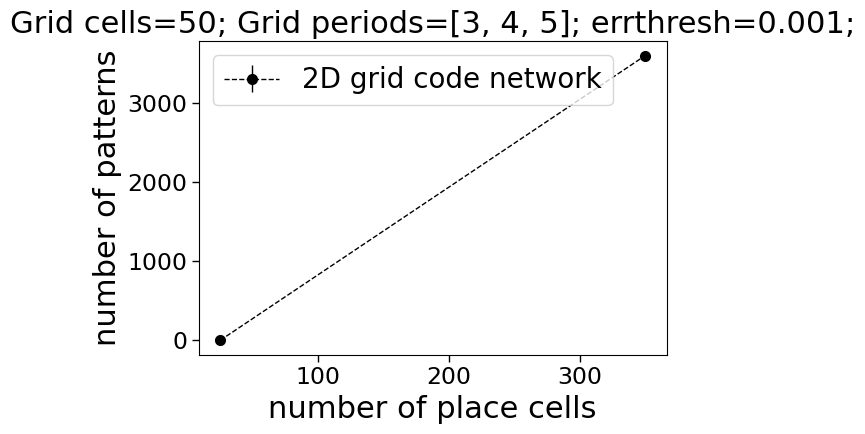

In [6]:
##Compute capacity across values of Np. This particular code designed assuming typical capacity estimation
## Does not work if generalization is being tested. Use the cell below if generalization is being tested

errthresh = 0.001 #Some tiny nonzero value above possible floating point error

capacity = -1*np.ones((len(Np_lst), nruns))
valid = err_gcpc <= errthresh   # bool
for Np in range(len(Np_lst)):
    # Original conservative
    for r in range(nruns):
      lst = np.argwhere(valid[Np,:,r] == False)
      #lst = np.argwhere(valid[Np,:] == False)
      if len(lst) == 0:
        #print("full capacity")
        capacity[Np,r] = Npos
      else:      
        bef_err = lst[0]-1
        bef_err = bef_err*(bef_err>0)  #Don't want to return -1 if lst[0]=0
        capacity[Np,r] = Npatts_lst[bef_err]

avg_cap = np.mean(capacity, axis=1)   # mean error over runs
#std_cap = stats.sem(capacity, axis=1)    # std dev over runs
std_cap = np.std(capacity, axis=1)    # std dev over runs



fig, ax = plt.subplots()
ax.errorbar(Np_lst, avg_cap, yerr=std_cap, fmt='ko--', label='2D grid code network')
add_labels(ax, f"Grid cells={Ng}; Grid periods={lambdas}; errthresh={errthresh};", "number of place cells", "number of patterns")
# savefig(fig, ax, f"{results_dir}/{filename}")
plt.show()


## Generalization Testing: Fixed Point Analysis

This cell provides an alternative analysis specifically for generalization experiments (when `test_generalization='yes'` is used in the previous cell).

### **Purpose:**
- Instead of measuring capacity, this analyzes how many correct fixed points the network generates
- Tests the network's ability to generalize from trained patterns to new ones
- Useful for understanding the network's interpolation and extrapolation capabilities

### **Key Metrics:**
- **x-axis**: Number of trained patterns (`Npatts_lst`)
- **y-axis**: Number of successfully generated fixed points (`num_correct`)
- **Error bars**: Show variability across experimental runs
- **Multiple curves**: One for each place cell count (`Np_lst`)

### **Interpretation:**
- Higher curves indicate better generalization performance
- Steeper slopes suggest more efficient learning
- Plateau regions show saturation of generalization capacity

**Important**: Make sure to set `test_generalization='yes'` in the experiment cell above when using this analysis!

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

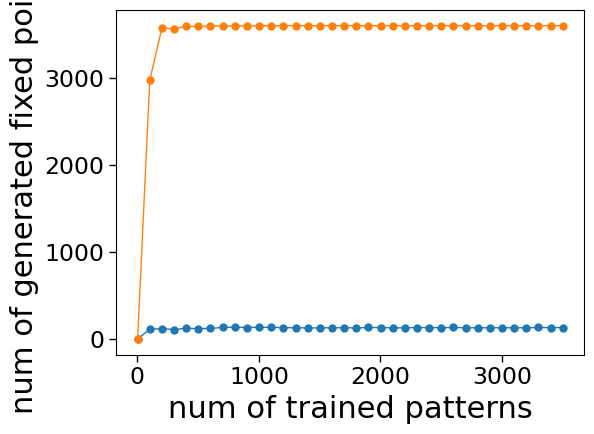

In [5]:
#When computing capacity for generalization plot, can simply plot mean and std of num_correct as below. 
#Make sure to pass test_generalization='yes' if doing this!

[plt.errorbar(x=Npatts_lst,y=num_correct[i].mean(axis=1),yerr=num_correct[0].std(axis=1),label='Np='+str(Np_lst[i]), marker='o',mew=0) for i in range(len(Np_lst))]
plt.xlabel('num of trained patterns')
plt.ylabel('num of generated fixed points')
plt.show()


## Basin of Attraction Analysis: Noise Robustness Testing

This cell implements a comprehensive analysis of the network's basin of attraction - how robust stored memories are to noise corruption.

### **Experimental Setup:**
- **Fixed Parameters**: Uses [3,4,5] grid modules, 400 place cells, 60% connectivity
- **Threshold**: 0.5 (lower than typical 2.0-2.5 for capacity tests)
- **Network Architecture**: Standard grid-cell to place-cell to grid-cell loop

### **Basin Size Measurement Process:**

1. **Network Training**:
   - Generate grid codebook and place cell responses
   - Train bidirectional connections (Wpg: grid→place, Wgp: place→grid)

2. **Noise Injection**:
   - Add Gaussian noise to stored place cell patterns
   - Noise levels: 0 to 10.5 times the mean pattern norm
   - Test 100 independent noise realizations

3. **Recovery Testing**:
   - Initialize with noisy patterns
   - Run through grid CAN dynamics (`gridCAN_2d`)
     *p.s.:*The function of `gridCAN_2d` is to clear "noise" .For every module, only the strongest activated one will be saved and set to 1.
     *p.p.s:*Why every “Module”？go back to the paper.
   - Check if network recovers original patterns (error < 1e-6)

### **Visualization:**
- **Gray lines**: Recovery probability for individual patterns
- **Black line**: Average recovery probability across all patterns
- **x-axis**: Relative noise magnitude (|noise|/|pattern|)
- **y-axis**: Probability of correct recovery

### **Interpretation:**
- Steep drop-off indicates narrow basins of attraction
- Gradual decline suggests robust memory storage
- Pattern-to-pattern variability shows heterogeneous basin sizes

thresh=0.5


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following 

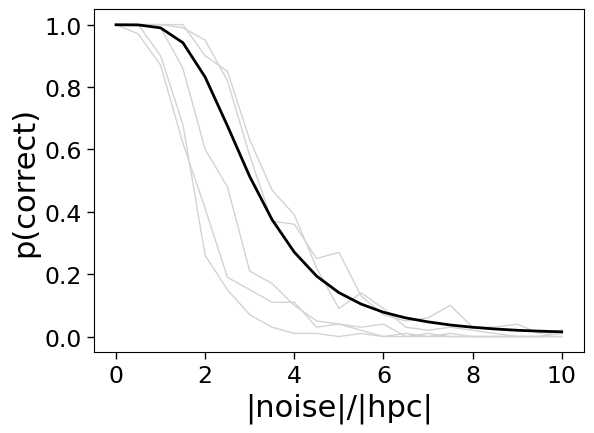

In [ ]:
#Barebones code to examine basin sizes

lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
Npos = Npos*Npos
gbook = gen_gbook([l**2 for l in lambdas],Ng,Npos)
nruns=1
Np = 400


#####This part is trying to sparese the codebook
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh=0.5

print('thresh='+str(thresh))

######This is the definition of pbook,if u are not familiar with it,please go back to CELL 2.
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # (nruns, Np, Npos)


Wgp = train_gcpc(pbook, gbook, Npos)

######Caulculate L2 norm of pbook
mean_p_norm = np.mean(np.linalg.norm(pbook,axis=1))

noise_vals = np.arange(0,10.5,0.5)
basin_runs = 100
correct = np.zeros((basin_runs,len(noise_vals),Npos))
for bidx in tqdm(range(basin_runs)):
    # noise =  np.random.normal(0,1,pbook.shape)/np.sqrt(Np)
    for nidx,noise_val in enumerate((noise_vals)):
        noise = np.random.normal(0,1,pbook.shape)/np.sqrt(Np)
        pinit = pbook + noise_val*noise*mean_p_norm
        gin = Wgp@pinit

  
        g = gridCAN_2d(gin,lambdas)
        
        p = nonlin(Wpg@g, thresh)
        
        
        err = np.linalg.norm(p - pbook,axis=1)
        correct[bidx,nidx] = err.squeeze()#<1e-6
     
correct_valid = correct<1e-6
correct_per_pat = correct_valid.mean(axis=0)

[plt.plot(noise_vals,correct_per_pat[:,i],color='lightgray') for i in np.random.randint(0,Npos,5)];
plt.plot(noise_vals,correct_per_pat.mean(axis=1),'k',lw=2.);
plt.xlabel(r'|noise|/|hpc|');
plt.ylabel('p(correct)');
# plt.title('Npatts = '+str(Npatts))
# plt.xlim(0,0.5)
# plt.ylim(0,1)
# plt.savefig('s_basin_cdf_Npatts_'+str(Npatts)+'.pdf')